## Applying the ML model to new data 

In [1]:
import tensorflow as tf
from matplotlib.pyplot import specgram
import glob 
import os
import sys
import json
import seaborn as sns
import pickle
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import json
import keras
from keras.models import Model, model_from_json

# ignore warnings
import warnings
warnings.simplefilter('ignore')

/opt/anaconda3/envs/Python-3-6/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using TensorFlow backend.


In [2]:
# loading json and model architecture 
json_file = open('MLModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("Augmented_Model.h5")
print("Loaded model from disk")
 
# compile loaded model
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


In [3]:
filename = 'labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

## Perform sentiment analysis on lecture audio

In [4]:
mydir ="lecture_chunks/"
lists_of_files = os.listdir(mydir)

In [5]:
lists_of_files[:5]

['chunk659.wav',
 'chunk881.wav',
 'chunk895.wav',
 'chunk665.wav',
 'chunk103.wav']

In [6]:
lecture_predictions = pd.DataFrame(columns=['predictions'])

for filename in lists_of_files:
    try:
        data, sample_rate = librosa.load("lecture_chunks/{}".format(filename),
                                         res_type='kaiser_fast',
                                         sr=44100)
        print(filename)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13),axis=0)
        newdf = pd.DataFrame(data=mfccs).T
        
        # Apply predictions
        newdf= np.expand_dims(newdf, axis=2)
        newpred = loaded_model.predict(newdf,batch_size=16,verbose=1)
        
        # Get the final predicted label
        final = newpred.argmax(axis=1)
        final = final.astype(int).flatten()
        final = (lb.inverse_transform((final)))
        #print(final)
        lecture_predictions.loc[filename] = final
        
    except:
        pass

chunk659.wav
1/1 [==============================] - 0s 253ms/step
chunk881.wav
1/1 [==============================] - 0s 7ms/step
chunk895.wav
1/1 [==============================] - 0s 6ms/step
chunk665.wav
1/1 [==============================] - 0s 6ms/step
chunk103.wav
1/1 [==============================] - 0s 5ms/step
chunk1082.wav
1/1 [==============================] - 0s 4ms/step
chunk1096.wav
1/1 [==============================] - 0s 4ms/step
chunk117.wav
1/1 [==============================] - 0s 7ms/step
chunk671.wav
1/1 [==============================] - 0s 5ms/step
chunk842.wav
1/1 [==============================] - 0s 6ms/step
chunk1069.wav
1/1 [==============================] - 0s 8ms/step
chunk856.wav
1/1 [==============================] - 0s 40ms/step
chunk1041.wav
1/1 [==============================] - 0s 6ms/step
chunk1055.wav
1/1 [==============================] - 0s 7ms/step
chunk329.wav
1/1 [==============================] - 0s 4ms/step
chunk1280.wav
1/1 [=============

In [7]:
lecture_predictions.head()

,predictions
chunk659.wav,negative
chunk881.wav,negative
chunk895.wav,neutral
chunk665.wav,negative
chunk103.wav,negative


In [8]:
lecture_predictions.predictions.value_counts()

negative    765
positive    557
neutral     301
Name: predictions, dtype: int64

In [9]:
labels = lecture_predictions.predictions.value_counts(normalize=True).keys().tolist()

values= []
for i in lecture_predictions.predictions.value_counts(normalize=True).tolist():
    values.append(round(i,2))

print(labels)
print(values)

['negative', 'positive', 'neutral']
[0.47, 0.34, 0.19]


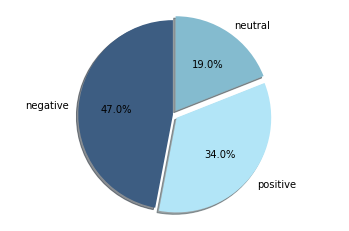

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm

colors = ['#3d5d82', '#b2e5f7', '#84bbcf'] 

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = labels
sizes = values
explode = (0, 0.05, 0.05)  # only "explode" the 2nd & 3rd slices (i.e. 'good', 'neutral')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors,
        shadow=True, startangle=90) 
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()